# ***CODE***

In this file, we have loaded pretrained model of YOLOV3 and UNET-RESNET34.

We also trained the linear regression model for Distance Estimation in meters.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **Linear Regression Model**

In [2]:
#Loading the libraries.
import numpy as np
import cv2 as cv
import imutils
import subprocess
import time
import os
import matplotlib.pyplot as plt

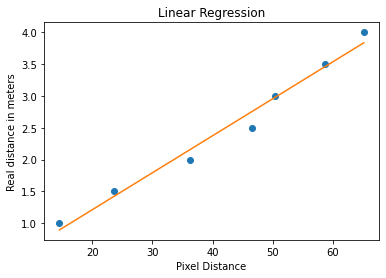

In [3]:
x=np.array([14.5001,23.5645,36.2180,46.5987,50.4541,58.7620,65.1920]) # compared pixel distance through images
y=np.array([1,1.5,2,2.5,3,3.5,4])  # Real distance recorded in meters.
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)


plt.plot(x, m*x + b)
plt.ylabel("Real distance in meters")
plt.xlabel("Pixel Distance")
plt.title("Linear Regression")
plt.show()

In [4]:
#the image is divided into three parts (Left,Centre,Right) and the object that follows in any of these parts, its distance is calculated with respect to thatpart centre.
def distance(img,a,b):
    if (0<a<img.shape[1]/3):
        dis=np.sqrt(((int(img.shape[1]/6)-a)**2)+((img.shape[0]-b)**2))
    if (img.shape[1]/3<a<img.shape[1]*2/3):
        dis=np.sqrt(((int(img.shape[1]/2)-a)**2)+((img.shape[0]-b)**2))
    if (img.shape[1]*2/3<a<img.shape[1]):
        dis=np.sqrt(((int((img.shape[1]*2/3)+(img.shape[1]/6))-a)**2)+((img.shape[0]-b)**2))
    return dis

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
linear_model = LinearRegression()
linear_model.fit(x.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
linear_model.score(x.reshape(-1, 1), y)

0.9805541979507485

# **Model for Road Condition Detection**

In [8]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks.hooks import *
from pathlib import Path
from fastai.utils.mem import *
from PIL import Image as PImage
torch.backends.cudnn.benchmark=True

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [10]:
path = Path('gdrive/My Drive/Colab Notebooks/')
path.ls()

[PosixPath('gdrive/My Drive/Colab Notebooks/codes.txt'),
 PosixPath('gdrive/My Drive/Colab Notebooks/.ipynb_checkpoints'),
 PosixPath('gdrive/My Drive/Colab Notebooks/valid.txt'),
 PosixPath('gdrive/My Drive/Colab Notebooks/colourlabels'),
 PosixPath('gdrive/My Drive/Colab Notebooks/images'),
 PosixPath('gdrive/My Drive/Colab Notebooks/labels'),
 PosixPath('gdrive/My Drive/Colab Notebooks/Untitled0.ipynb'),
 PosixPath('gdrive/My Drive/Colab Notebooks/RoadSurfaceSegmentation.ipynb'),
 PosixPath('gdrive/My Drive/Colab Notebooks/TEST.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/test_video.mp4'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathole5.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathole4.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathole3.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathhole2.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathhole1.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/pathhole5.jpg'),
 PosixPath('gdrive/My Drive/Col

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved', 'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'craks'], dtype='<U12')

In [12]:
path_lbl = path/'labels'
path_img = path/'images'

In [13]:
fnames = get_image_files(path_img)
fnames[:3]
len(fnames)

701

In [14]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]
len(lbl_names)

701

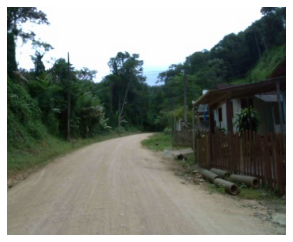

In [15]:
img_f = fnames[139]
img = open_image(img_f)
img.show(figsize=(5,5))

In [16]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

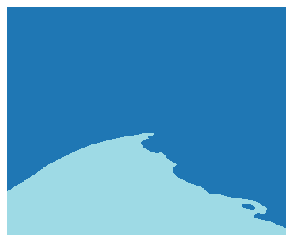

In [17]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [18]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([288, 352]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

In [19]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))
size = src_size
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=4)
        .normalize(imagenet_stats))

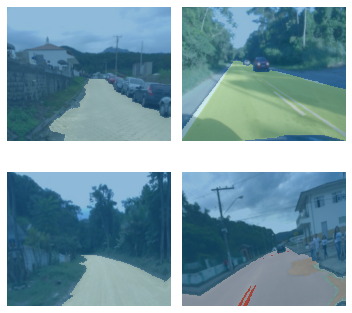

In [20]:
data.show_batch(5, figsize=(5,5)) #example from dataset with there masks

In [21]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics=acc_rtk
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn=load_learner(path,'my_export.pkl')         # loading the self-trained model(from UNETRESNET34 train file)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


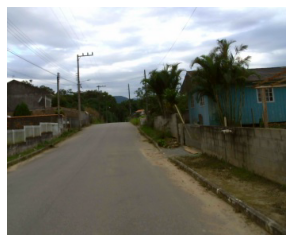

In [23]:
img_f = fnames[34]
img = open_image(img_f)
img.show(figsize=(5,5))

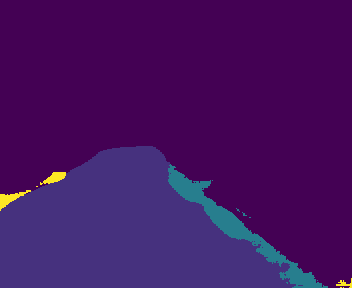

In [24]:
prediction = learn.predict(img)
prediction[0]  #mask predicted

# **Coloring the different segments **

In [25]:
%load_ext cython

In [26]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (85,85,255) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (85,85,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (85,85,255)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (85,85,255) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (85,85,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [27]:
frame = colorfull_fast(cv.cvtColor(image2np(prediction[0].data).astype(np.uint8), cv.COLOR_GRAY2RGB)) # colouring the predicted mask to represent each class uniquely

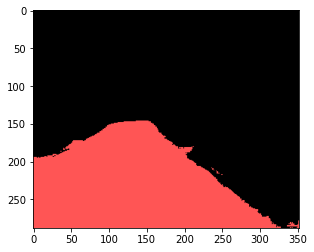

In [28]:
plt.imshow(frame)

# **Model for Object Detection**

In [29]:
def draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels):
    # If there are any detections
    if len(idxs) > 0:
        
        for i in idxs.flatten():
            # Get the bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]
            
            a=x+int(w/2)
            b=y+h
            dis=distance(img,a,b)
            y_pred = linear_model.predict(np.array(dis).reshape(1,-1))
            all_dist.append(y_pred[0])
            # Get the unique color for this class
            color = [int(c) for c in colors[classids[i]]]

            # Draw the bounding box rectangle and label on the image
            cv.rectangle(img, (x, y), (x+w, y+h), color, 2)
            text = "{}: {:.2f}".format(labels[classids[i]],float(y_pred[0]))
            cv.putText(img, text, (x, y-5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
       
       cmd,objectname=decision_making(idxs,boxes,confidences,labels,classids) 
       generating_commands(cmd,object_name)    
            
    return img

In [30]:
def generate_boxes_confidences_classids(outs, height, width, tconf):
    boxes = []
    confidences = []
    classids = []

    for out in outs:
        for detection in out:
            #print (detection)
            #a = input('GO!')

            # Get the scores, classid, and the confidence of the prediction
            scores = detection[5:]
            classid = np.argmax(scores)
            confidence = scores[classid]

            # Consider only the predictions that are above a certain confidence level
            if confidence > tconf:
                # TODO Check detection
                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, bwidth, bheight = box.astype('int')

                # Using the center x, y coordinates to derive the top
                # and the left corner of the bounding box
                x = int(centerX - (bwidth / 2))
                y = int(centerY - (bheight / 2))

                # Append to list
                boxes.append([x, y, int(bwidth), int(bheight)])
                confidences.append(float(confidence))
                classids.append(classid)

    return boxes, confidences, classids

In [31]:
def infer_image(net, layer_names, height, width, img, colors, labels, 
            boxes=None, confidences=None, classids=None, idxs=None, infer=True):

    if infer:
        # Contructing a blob from the input image
        blob = cv.dnn.blobFromImage(img, 1 / 255.0, (416, 416),
                        swapRB=True, crop=False)

        # Perform a forward pass of the YOLO object detector
        net.setInput(blob)

        # Getting the outputs from the output layers
        outs = net.forward(layer_names)



        # Generate the boxes, confidences, and classIDs
        boxes, confidences, classids = generate_boxes_confidences_classids(outs, height, width,0.5)

        # Apply Non-Maxima Suppression to suppress overlapping bounding boxes
        idxs = cv.dnn.NMSBoxes(boxes, confidences,0.5, 0.3)

    if boxes is None or confidences is None or idxs is None or classids is None:
        raise '[ERROR] Required variables are set to None before drawing boxes on images.'

    # Draw labels and boxes on the image
    img = draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels)

    return img, boxes, confidences, classids, idxs


In [35]:
weights=open(path/'yolov3.weights','rb').read()
cfg=open(path/'yolov3.cfg','rb').read()
labels=path/'coco-labels'
confidence=0.5
threshold=0.3                      #Loading the data

In [36]:
# Get the labels
labels = open(labels).read().strip().split('\n')

In [37]:
labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [38]:
# Intializing colors to represent each label uniquely
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')


In [39]:
# Load the weights and configutation to form the pretrained YOLOv3 model
net = cv.dnn.readNetFromDarknet(cfg,weights)

In [40]:
# Get the output layer names of the model
layer_names = net.getLayerNames()
layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]


## **Decision making and command generating**

In [42]:
import pyttsx3
def generating_commands(cmd,object_name):
  engine = pyttsx3.init()
  if cmd='left':
    engine.say("Move left")
  if cmd='right':
    engine.say("Move right")
  if cmd='stop':
    engine.say("stop")
  if cmd='countine':
    engine.say("countinue on same path")
  if object_name:
    engine.say("Object detected" + object_name)
  else:
    pass


def decision_making(idxs,boxes,confidences,labels,classids):
  if len(idxs) > 0:
        all_dis_left=[]
        all_dis_middle=[]
        all_dis_right=[]
        object_name=[]
        for i in idxs.flatten():

          x, y = boxes[i][0], boxes[i][1]
          w, h = boxes[i][2], boxes[i][3]
                    
          a=x+int(w/2)
          b=y+h

          #appending the distances lying in same lane and then taking theobject having minimum distance
          if (0<a<img.shape[1]/3):
              dis_left=np.sqrt(((int(img.shape[1]/6)-a)**2)+((img.shape[0]-b)**2))
              all_dis_left.append(dis_left)
          if (img.shape[1]/3<a<img.shape[1]*2/3):
              dis_middle=np.sqrt(((int(img.shape[1]/2)-a)**2)+((img.shape[0]-b)**2))
              all_dis_middle.append(dis_middle)
              object_name(labels[classids[i]])
          if (img.shape[1]*2/3<a<img.shape[1]):
              dis_right=np.sqrt(((int((img.shape[1]*2/3)+(img.shape[1]/6))-a)**2)+((img.shape[0]-b)**2))
              all_dis_right.append(dis_right)
  
  
   dis_left=min(all_dis_left)
   dis_middle=min(all_dis_middle)
   dis_right=min(all_dis_right)
   
   if(dis_middle!=None):

     object_name=object_name(all_dis_middle.index(min(all_dis_middle)))
  #### now different cases based on the distances
   if (dis_middle==None):
     dis_middle=0
   if (dis_left==None):
     dis_left=0
   if (dis_right==None):
     dis_right=0
   if (0<dis_middle<3):            #this means object is in lane region
      if (dis_left=0 and dis_right=0):  #means no object on other 2 lanes
        cmd="left"
      elif (dis_left=0):             #object on right
        cmd="left"
      elif (dis_right=0):            #object on left
        cmd="right"
    
      if (dis_left !=0 and dis_right !=0):  #means object present on other 2 lanes
        if (dis_left>dis_right):           #object on right lane is closer
          cmd="left"
        if (dis_left<dis_right):           #object on left lane is closer
          cmd="right"
        if (dis_left==dis_right):           #object on  both lane are at same distance
           if (dis_left>dis_middle):          # but if they are behind the middle object
              cmd="left"
            if (dis_left<dis_middle or dis_left==dis_middle):          # but if they are even closer than middle object
              cmd="stop"
    else:
      cmd="countinue"
    
    return cmd,object_name




# **Merging the three models and running it on the outdoor test video**

In [43]:
output1=r'gdrive/My Drive/Colab Notebooks/Outddor_test_video6.mp4'
show=1
width=500

In [44]:
input1=r'gdrive/My Drive/Colab Notebooks/123123.mp4'

In [45]:
import cv2

In [46]:
vs = cv2.VideoCapture(input1)
writer = None
# try to determine the total number of frames in the video file

prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
    else cv2.CAP_PROP_FRAME_COUNT
total = int(vs.get(prop))
print("[INFO] {} total frames in video".format(total))

[INFO] 1018 total frames in video


In [47]:
height=None
width=None
value=1
count=0
while(value == True):
    # read the next frame from the file
    (grabbed, frame) = vs.read()
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break
    # construct a blob from the frame and perform a forward pass
    # using the segmentation model
    start = time.time()
    

    frame=cv2.resize(frame,(352,288))
    
    frame1= pil2tensor(PImage.fromarray(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)),np.float32)
    
    prediction = learn.predict(Image(frame1/255))
    
    
    road_detection_mask= colorfull_fast(cv.cvtColor(image2np(prediction[0].data).astype(np.uint8), cv.COLOR_GRAY2RGB))
    
    
    if width is None or height is None:
        height, width = frame.shape[:2]

    final_out, _, _, _, _ = infer_image(net, layer_names, height, width, frame, colors, labels)
    output = ((0.4*final_out)+ (0.6*road_detection_mask)).astype("uint8")
   
    end = time.time()
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(output1, fourcc, 20,
            (output.shape[1], output.shape[0]), True)
        # some information on processing single frame
    if total > 0:
        elap = (end - start)
        
        
    # write the output frame to disk
    writer.write(output)
    if 1 > 0:
       
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
# release the file pointers


writer.release()
vs.release()